## 1. Import statements

In [225]:
import numpy as np
import matplotlib.pyplot as plt
import egttools as egt


## 2. Global variables

In [226]:
R = 1
S = -1
T = 2
P = 0

NUM_ROUNDS = 50  # number of rounds
N = 100  # population size
BETA = 0.1
THETA = 3  # trust threshold
EPSILON = 0.25  # opportunity cost
CHECK_PROBABILITY = 0.25 # p

STRATEGIES = ["AllC", "AllD", "TFT", "TUC", "TUD"]  # Strategy names

STRATEGY_COLORS = {  # for plotting
    "AllC": "lightgreen",
    "AllD": "red",
    "TFT": "blue",
    "TUC": "purple",
    "TUD": "orange",
}

## 3. Payoff matrix
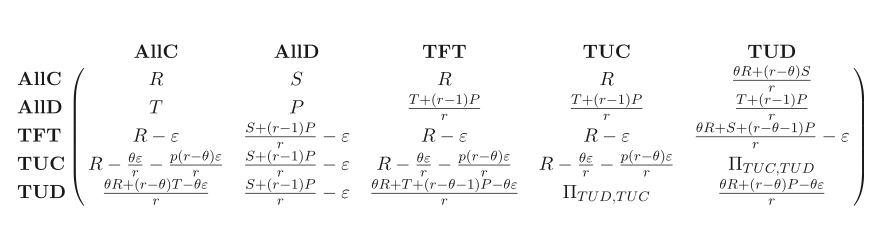
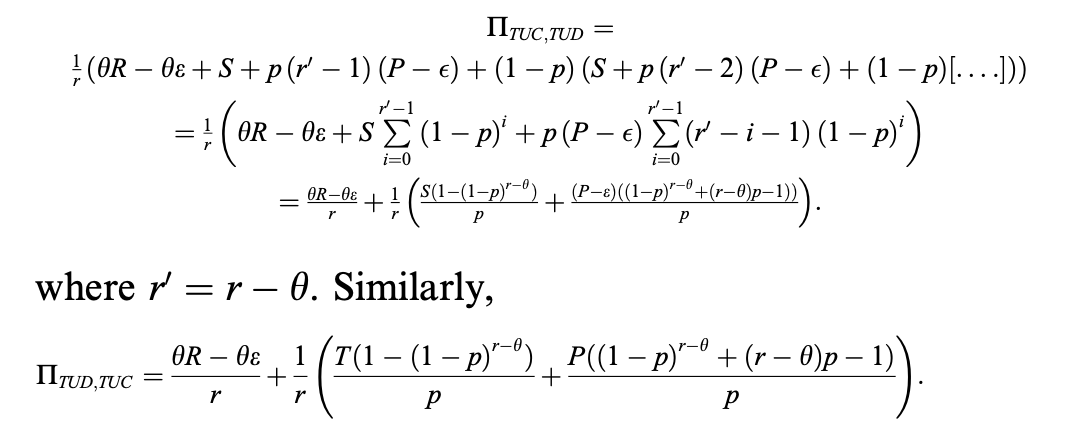

In [227]:
def initialize_payoff_matrix(
    # 1) payoff matrix weights
    R: int,  # reward
    S: int,  # sucker
    T: int,  # temptation
    P: int,  # punishment
    # 2) trust metrics
    theta: int,
    check_co_player_probability: int,
    # 3) game variables
    epsilon: int,  # opportunity cost
    r: int,  # number of (repeated) rounds
    with_trust_based_strategies: bool = True,  # whether to add TUC / TUD (to differentiate whether cooperation improves in experiments)
):

    # helper function to divide by the number of rounds
    def norm_rounds(expr):
        return expr / r

    # helper function to normalize AND subtract opportunity cost
    def norm_and_opp_cost(expr):
        return norm_rounds(expr) - epsilon

    def tuc_vs_tud():
        return norm_rounds(theta * R - theta * epsilon) + 1 / r * (
            (S * (1 - (1 - check_co_player_probability) ** (r - theta)))
            / check_co_player_probability
            + (
                (P - epsilon)
                * (
                    (1 - check_co_player_probability) ** (r - theta)
                    + (r - theta) * check_co_player_probability
                    - 1
                )
            )
            / check_co_player_probability
        )

    def tud_vs_tuc():
        return norm_rounds(theta * R - theta * epsilon) + 1 / r * (
            (T * (1 - (1 - check_co_player_probability) ** (r - theta)))
            / check_co_player_probability
            + (
                P
                * (
                    (1 - check_co_player_probability) ** (r - theta)
                    + (r - theta) * check_co_player_probability
                    - 1
                )
            )
            / check_co_player_probability
        )

    complete_payoff = [
        # A11C
        [R, S, R, R, norm_rounds(theta * R + (r - theta) * S)],
        # A11D
        [
            T,
            P,
            norm_rounds(T + (r - 1) * P),
            norm_rounds(T + (r - 1) * P),
            norm_rounds(T + (r - 1) * P),
        ],
        # TFT
        [
            R - epsilon,
            norm_and_opp_cost(S + (r - 1) * P),
            R - epsilon,
            R - epsilon,
            norm_and_opp_cost(theta * R + S + (r - theta - 1) * P),
        ],
        # TUC
        [
            R
            - norm_rounds(theta * epsilon)
            - norm_rounds(check_co_player_probability * (r - theta) * epsilon),
            norm_and_opp_cost(S + (r - 1) * P),
            R
            - norm_rounds(theta * epsilon)
            - norm_rounds(check_co_player_probability * (r - theta) * epsilon),
            R
            - norm_rounds(theta * epsilon)
            - norm_rounds(check_co_player_probability * (r - theta) * epsilon),
            tuc_vs_tud(),
        ],
        # TUD
        [
            norm_rounds(theta * R + (r - theta) * T - theta * epsilon),
            norm_and_opp_cost(S + (r - 1) * P),
            norm_rounds(theta * R + T + (r - theta - 1) * P - theta * epsilon),
            tud_vs_tuc(),
            norm_rounds(theta * R + (r - theta) * P - theta * epsilon),
        ],
    ]

    return (
        complete_payoff
        if with_trust_based_strategies
        else [row[:3] for row in complete_payoff[:3]]
    )

### Extra helper methods for result reproduction

In [228]:
def get_cooperation_rates(r, theta):
    # Returns cooperation rates for AllC, AllD, TFT, TUC, TUD
    return np.array([1.0, 0.0, 1.0, 1.0, theta / r])


def run_simulation(matrix, beta, N):
    # Calculate stationary distribution for full 5x5 game
    matrix = np.array(matrix)
    game = egt.games.Matrix2PlayerGameHolder(5, matrix)
    evolver = egt.analytical.PairwiseComparison(N, game)
    transition_matrix, _ = evolver.calculate_transition_and_fixation_matrix_sml(beta)
    return egt.utils.calculate_stationary_distribution(transition_matrix.transpose())


def run_simulation_baseline(matrix, beta, N):
    # Calculate stationary distribution for baseline 3x3 game (AllC, AllD, TFT)
    matrix = np.array(matrix)
    sub_matrix = matrix[:3, :3]
    game = egt.games.Matrix2PlayerGameHolder(3, sub_matrix)
    evolver = egt.analytical.PairwiseComparison(N, game)
    transition_matrix, _ = evolver.calculate_transition_and_fixation_matrix_sml(beta)
    return egt.utils.calculate_stationary_distribution(transition_matrix.transpose())

## Figure 3a

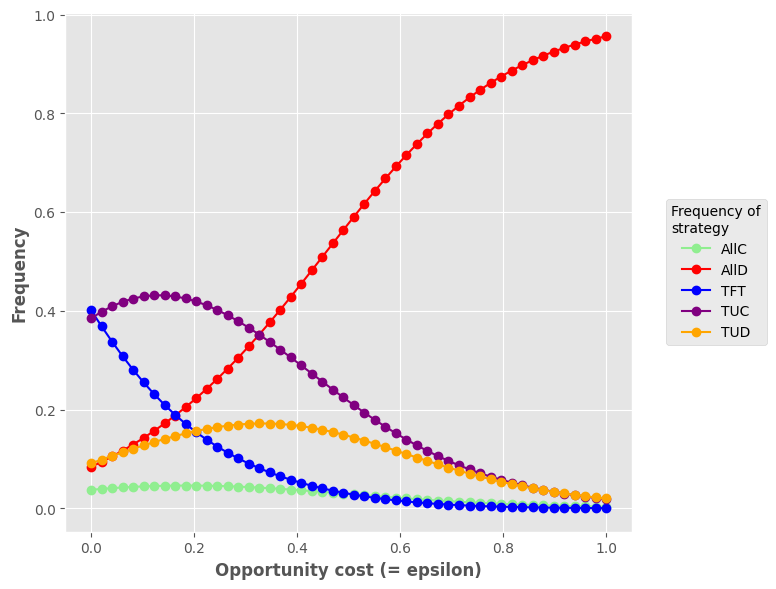

In [229]:
epsilon_values = np.linspace(0, 1, 50)
strategy_frequency_data = {strat: [] for strat in STRATEGIES}

# 1) calculate data

# 1.1) iterate over the different values of opportunity cost
for eps in epsilon_values:
    # 1.2) generate pay-off matrix
    payoff_matrix = initialize_payoff_matrix(
        R=R,
        S=S,
        T=T,
        P=P,
        theta=THETA,
        check_co_player_probability=CHECK_PROBABILITY,
        epsilon=eps,
        r=NUM_ROUNDS,
    )

    # 1.2) get stationary distribution
    frequencies = run_simulation(payoff_matrix, BETA, N)

    # 1.3) store results
    for i, strat in enumerate(STRATEGIES):
        strategy_frequency_data[strat].append(frequencies[i])


# 2) plot the resultsd
plt.style.use(
    "ggplot"
)  # (for grey background: https://matplotlib.org/stable/gallery/style_sheets/ggplot.html)

# 2.1) iterate over the strategies -> plot each separately
fig, ax = plt.subplots(figsize=(8, 6))
for strat in STRATEGIES:
    # 2.2) plot!
    ax.plot(
        epsilon_values,
        strategy_frequency_data[strat],
        label=strat,
        color=STRATEGY_COLORS[strat],
        marker="o",
    )

# 2.3) label the axes
ax.set_xlabel("Opportunity cost (= epsilon)", fontweight="bold")
ax.set_ylabel("Frequency", fontweight="bold")

# 2.4) custom legend
legend = ax.legend(
    title="""Frequency of\nstrategy""", loc="center right", bbox_to_anchor=(1.25, 0.5)
)

plt.tight_layout()
plt.show()

## Figure 3b

In [230]:
cooperation_without_trust = []
cooperation_with_trust = []

# No Trust
without_cooperation_strategies = ["AllC", "AllD", "TFT"]

def cooperation_rate(strategy, theta, num_rounds):
    if strategy == "AllD":
        return 0
    elif strategy == "AllC":
        return 1
    elif strategy == "TFT":
        return 1
    elif strategy == "TUC":
        return 1
    elif strategy == "TUD":
        return theta/num_rounds
    
def cooperation_frequency(stationary, strategies, theta, num_rounds):
    rates = np.array([cooperation_rate(i, theta, num_rounds) for i in strategies])
    return float(np.dot(stationary, rates))


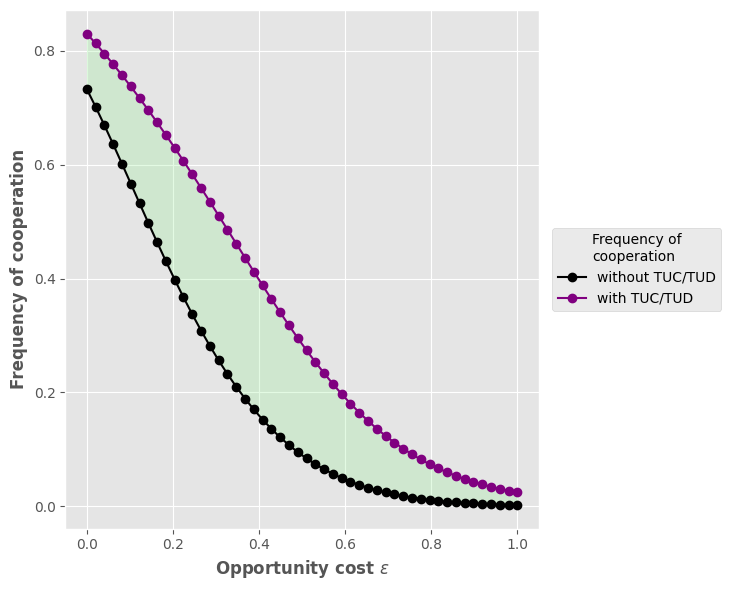

In [231]:
for eps in epsilon_values:

    payoff_matrix = initialize_payoff_matrix(
        R=R,
        S=S,
        T=T,
        P=P,
        theta=THETA,
        check_co_player_probability=CHECK_PROBABILITY,
        epsilon=eps,
        r=NUM_ROUNDS,
        with_trust_based_strategies=True,
    )

    stationary_without_trust = run_simulation_baseline(payoff_matrix, BETA, N)
    cooperation_without_trust.append(
        cooperation_frequency(
            stationary_without_trust, without_cooperation_strategies, THETA, NUM_ROUNDS
        )
    )


    stationary_with_trust = run_simulation(payoff_matrix, BETA, N)
    cooperation_with_trust.append(
        cooperation_frequency(stationary_with_trust, STRATEGIES, THETA, NUM_ROUNDS)
    )

cooperation_without_trust = np.array(cooperation_without_trust)
cooperation_with_trust = np.array(cooperation_with_trust)

diff = cooperation_with_trust - cooperation_without_trust


plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(
    epsilon_values,
    cooperation_without_trust,
    color="black",
    marker="o",
    label="without TUC/TUD",
)

ax.plot(
    epsilon_values,
    cooperation_with_trust,
    color="purple",
    marker="o",
    label="with TUC/TUD",
)

ax.fill_between(  # (source: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.fill_between.html)
    epsilon_values,
    cooperation_without_trust,
    cooperation_with_trust,
    where=None,
    color="lightgreen",
    alpha=0.25,
    interpolate=False,
)

ax.set_xlabel(r"Opportunity cost $\epsilon$", fontweight="bold")
ax.set_ylabel("Frequency of cooperation", fontweight="bold")


legend = ax.legend(
    title="""Frequency of\ncooperation""",
    loc="center right",
    bbox_to_anchor=(1.40, 0.5),
)
plt.tight_layout()
plt.show()

## Figure 3 & Figure 6 Reproduction

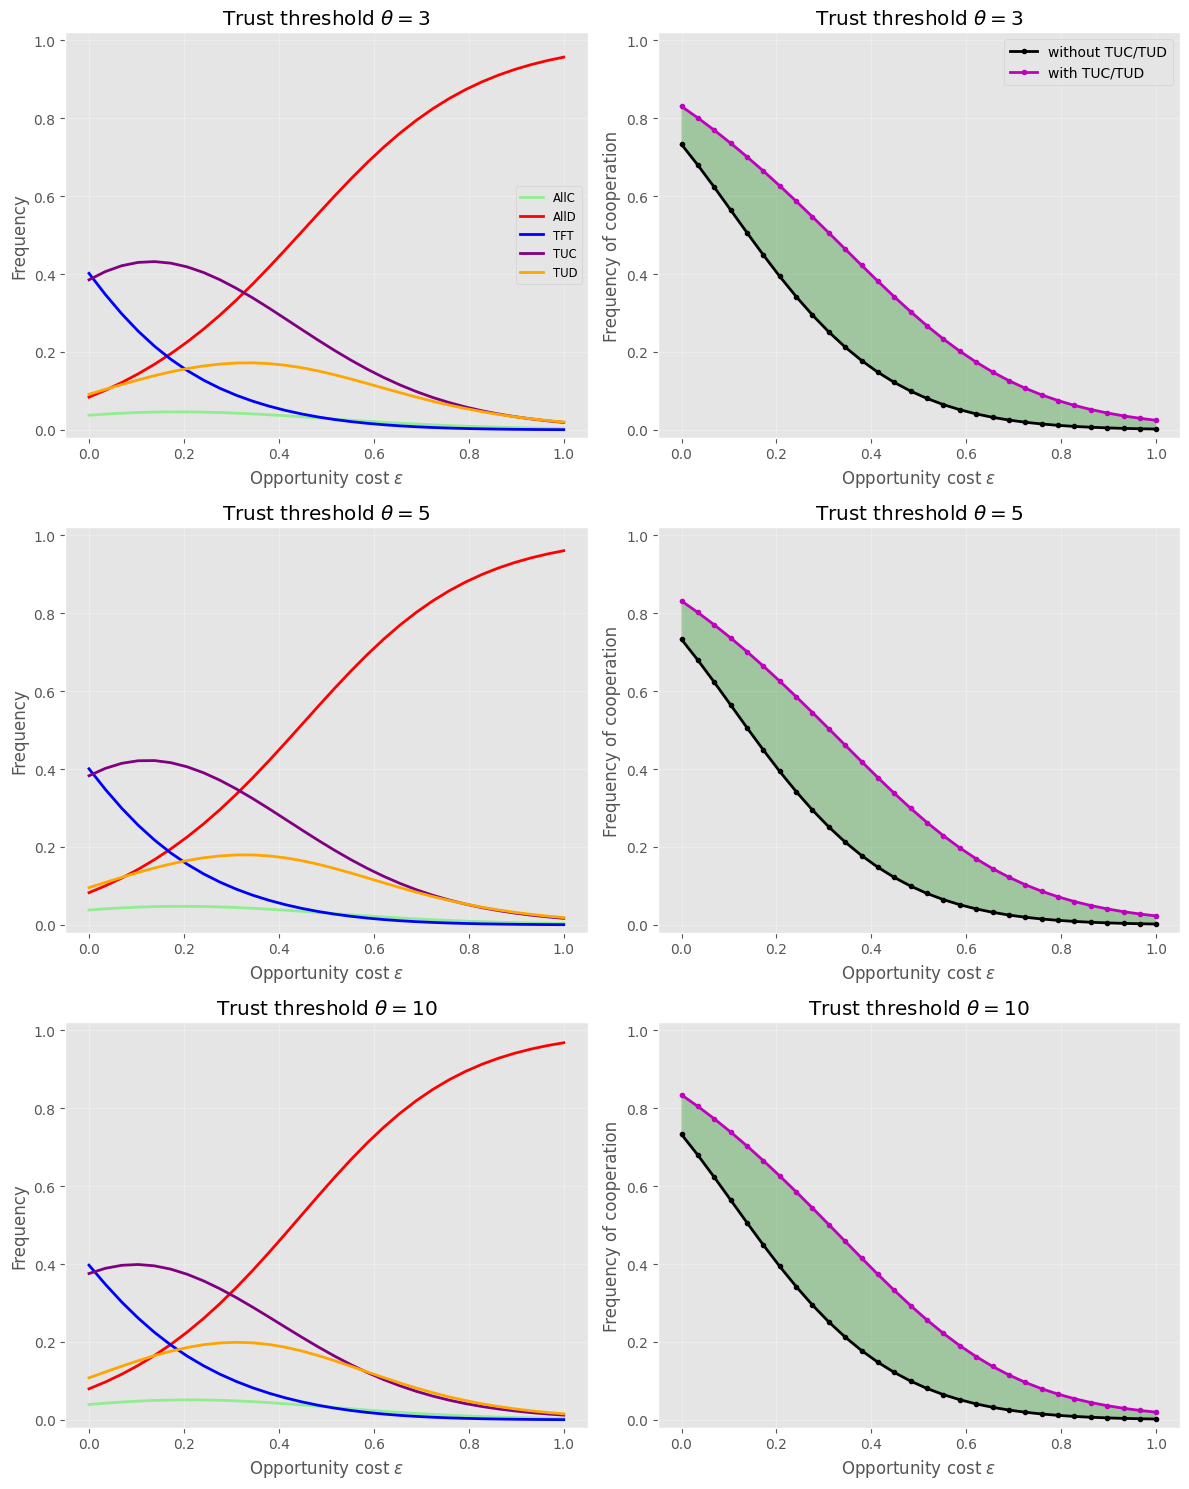

In [232]:
import numpy as np
import matplotlib.pyplot as plt


def generate_frequency_of_strats_plots():
    epsilons = np.linspace(0, 1, 30)

    thetas = [THETA, 5, 10]

    strategies = ["AllC", "AllD", "TFT", "TUC", "TUD"]
    colors = ["lightgreen", "red", "blue", "purple", "orange"]

    # Create a separate row of plots for each Theta value
    rows = len(thetas)
    _, axes = plt.subplots(rows, 2, figsize=(12, 5 * rows))

    for i, theta in enumerate(thetas):
        frequencies_strategies = []
        coop_with = []
        coop_without = []

        # Increase the cost (epsilon) to see when trust fails
        for eps in epsilons:
            payoff_matrix = initialize_payoff_matrix(
                R, S, T, P, theta, CHECK_PROBABILITY, eps, NUM_ROUNDS
            )

            # Evolution with Trust Strategies
            sd = run_simulation(payoff_matrix, BETA, N)
            frequencies_strategies.append(sd)
            coop_with.append(
                cooperation_frequency(
                    sd,
                    STRATEGIES,
                    theta,
                    NUM_ROUNDS,
                )
            )

            # Evolution without Trust Strategies
            # We need this to calculate the "green area" (Cooperation Gain) later
            sd_base = run_simulation_baseline(payoff_matrix, BETA, N)
            coop_without.append(
                cooperation_frequency(
                    sd_base,
                    without_cooperation_strategies,
                    theta,
                    NUM_ROUNDS,
                )
            )

        frequencies_strategies = np.array(frequencies_strategies)

        # Plotting Strategy (left side)
        ax_left = axes[i, 0]

        for strategy_idx in range(5):
            ax_left.plot(
                epsilons,
                frequencies_strategies[:, strategy_idx],
                label=strategies[strategy_idx],
                color=colors[strategy_idx],
                linewidth=2,
            )
        ax_left.set_ylim(-0.02, 1.02)
        ax_left.set_xlabel(r"Opportunity cost $\epsilon$")
        ax_left.set_ylabel("Frequency")
        ax_left.set_title(f"Trust threshold $\\theta = {theta}$")
        if i == 0:
            ax_left.legend(loc="center right", fontsize="small")
        ax_left.grid(True, alpha=0.3)

        # Plotting Cooperation (right side)
        ax_right = axes[i, 1]
        ax_right.plot(
            epsilons, coop_without, "k.-", label="without TUC/TUD", linewidth=2
        )
        ax_right.plot(epsilons, coop_with, "m.-", label="with TUC/TUD", linewidth=2)

        ax_right.fill_between(
            epsilons,
            coop_without,
            coop_with,
            where=(np.array(coop_with) > np.array(coop_without)),
            facecolor="green",
            alpha=0.3,
            interpolate=True,
        )
        ax_right.fill_between(
            epsilons,
            coop_without,
            coop_with,
            where=(np.array(coop_with) <= np.array(coop_without)),
            facecolor="red",
            alpha=0.3,
            interpolate=True,
        )

        ax_right.set_ylim(-0.02, 1.02)
        ax_right.set_xlabel(r"Opportunity cost $\epsilon$")
        ax_right.set_ylabel("Frequency of cooperation")
        ax_right.set_title(f"Trust threshold $\\theta = {theta}$")
        if i == 0:
            ax_right.legend()
        ax_right.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


generate_frequency_of_strats_plots()

## Figure 4 & Figure 7 Reproduction

c:\Users\Narli\.conda\envs\homework-1-conda-env\lib\site-packages\egttools\utils.py:215: RuntimeWarning: Some of the entries in the transition matrix are close to 1 (with a tolerance of 1e-11). This could result in more than one eigenvalue of magnitute 1 (the Markov Chain is degenerate), so please be careful when analysing the results.
  warn(


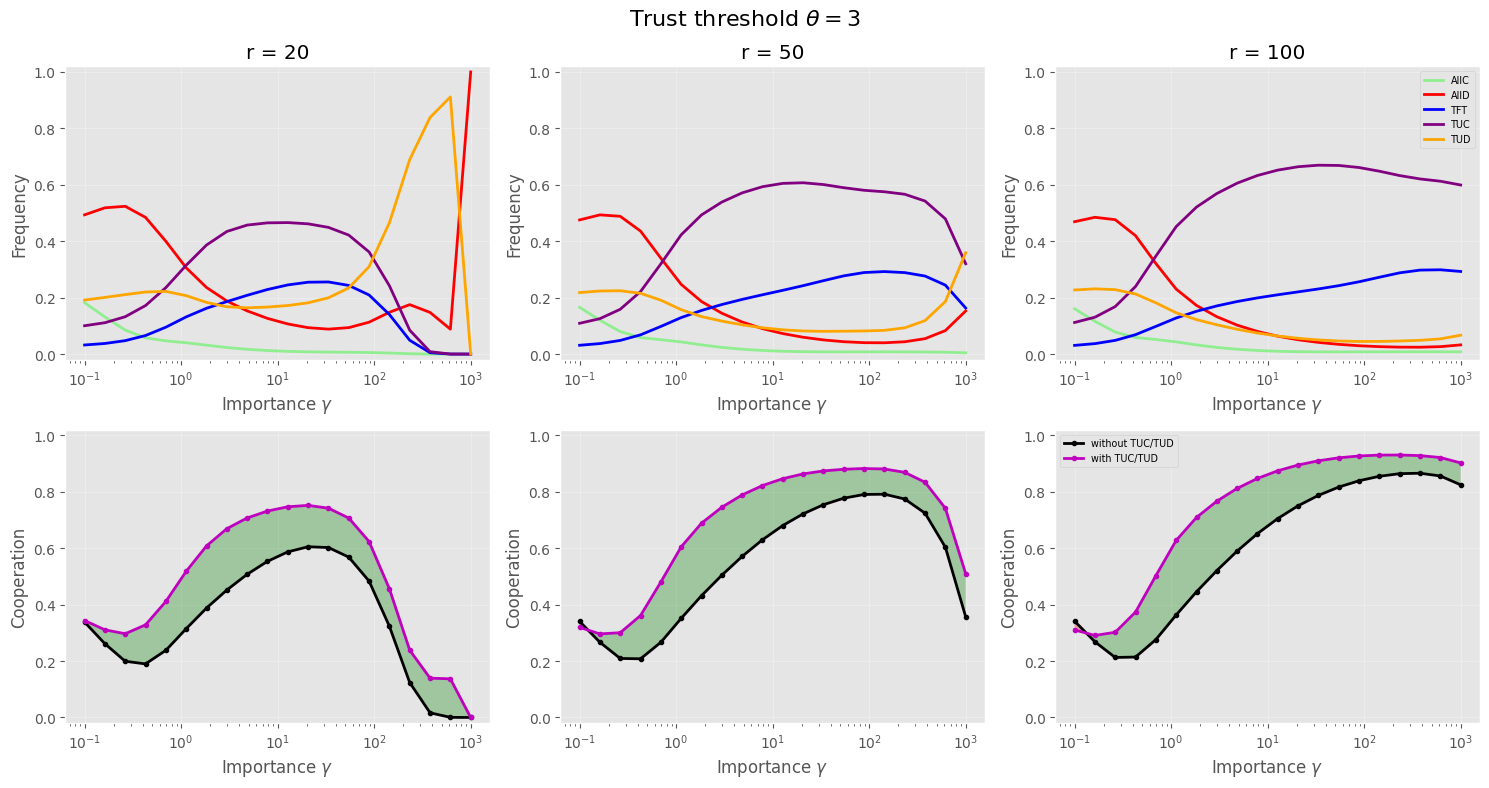

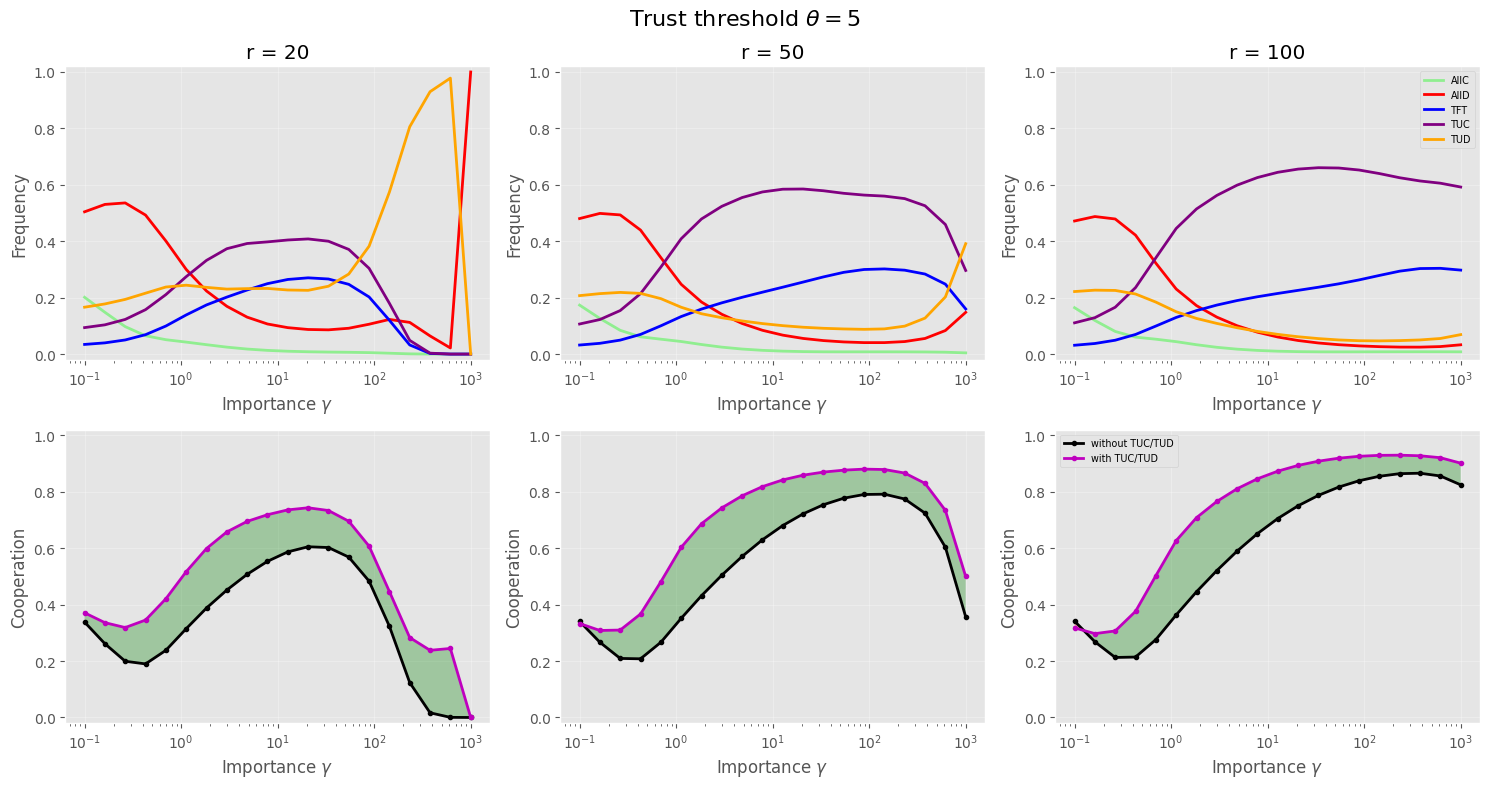

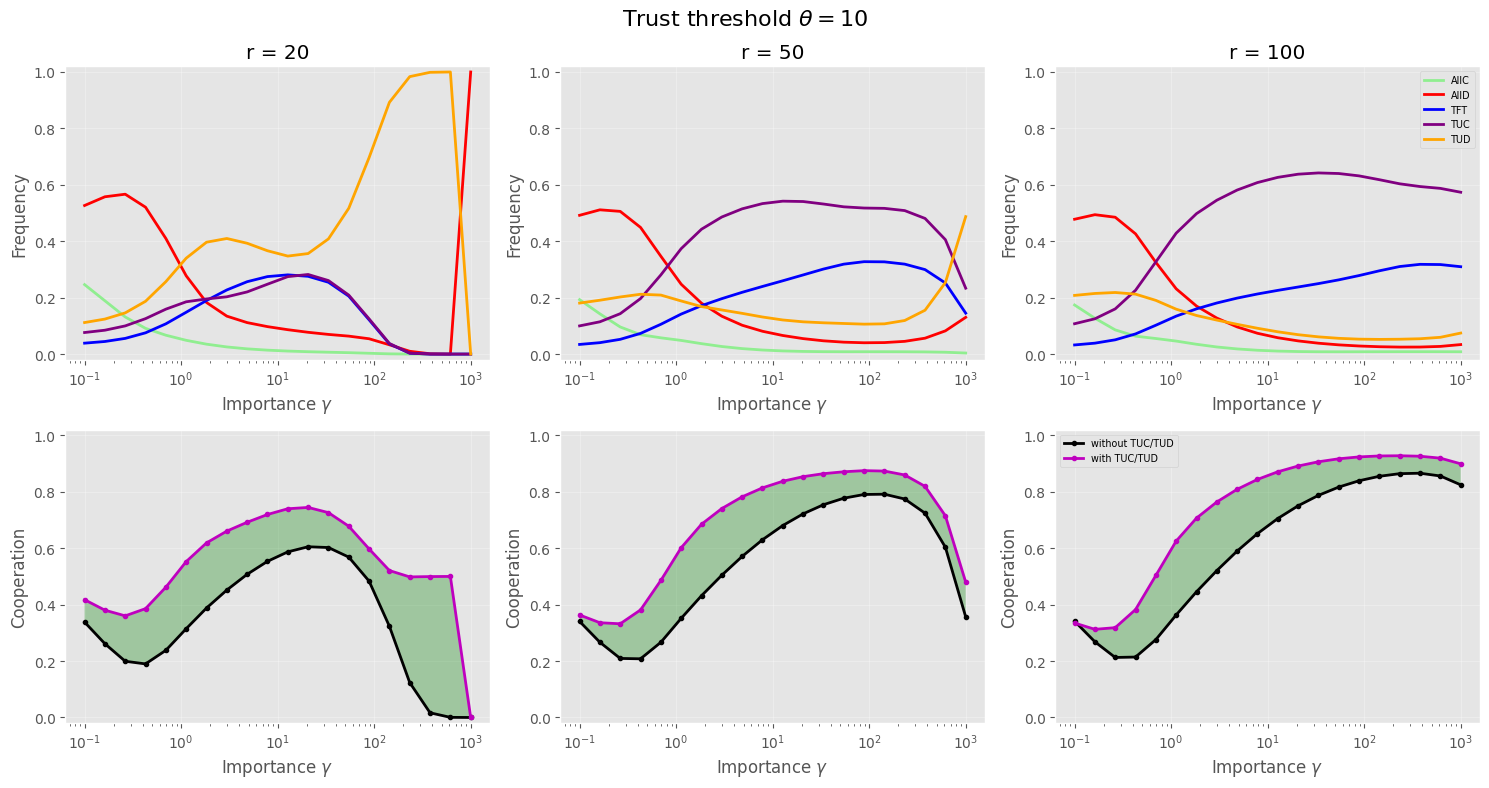

In [233]:
def generate_importance_plots():
    # Gamma varies
    gammas = np.logspace(-1, 3, 20)
    rounds_list = [20, 50, 100]
    thetas = [THETA, 5, 10]

    strategies = ["AllC", "AllD", "TFT", "TUC", "TUD"]
    colors = ["lightgreen", "red", "blue", "purple", "orange"]

    # Separate figure window for each Threshold (Theta)
    for theta in thetas:
        fig, axes = plt.subplots(2, 3, figsize=(15, 8))
        fig.suptitle(f"Trust threshold $\\theta = {theta}$", fontsize=16)

        # Iterate through short, medium and long games
        for j, rounds in enumerate(rounds_list):
            frequencies_strategies = []
            coop_with = []
            coop_without = []

            # Gradually increase importance (gamma)
            for gamma in gammas:
                # Scale the payoff matrix by Gamma (Payoffs get bigger, cost stays fixed)
                Rg = R * gamma
                Sg = S * gamma
                Tg = T * gamma
                Pg = P * gamma

                payoff_matrix = initialize_payoff_matrix(
                    Rg, Sg, Tg, Pg, theta, CHECK_PROBABILITY, EPSILON, rounds
                )

                # With Trust Strategies (TUC/TUD)
                sd = run_simulation(payoff_matrix, BETA, N)
                frequencies_strategies.append(sd)
                coop_with.append(
                    cooperation_frequency(
                        sd,
                        STRATEGIES,
                        theta,
                        rounds,
                    )
                )

                # Without Trust Strategies
                sd_base = run_simulation_baseline(payoff_matrix, BETA, N)
                coop_without.append(
                    cooperation_frequency(
                        sd_base,
                        without_cooperation_strategies,
                        theta,
                        rounds,
                    )
                )

            frequencies_strategies = np.array(frequencies_strategies)

            # Plot Strategies (Top row)
            ax_top = axes[0, j]
            for strategy_idx in range(5):
                ax_top.plot(
                    gammas,
                    frequencies_strategies[:, strategy_idx],
                    label=strategies[strategy_idx],
                    color=colors[strategy_idx],
                    linewidth=2,
                )
            ax_top.set_xscale("log")
            ax_top.set_ylim(-0.02, 1.02)
            ax_top.set_xlabel(r"Importance $\gamma$")
            ax_top.set_ylabel("Frequency")
            ax_top.set_title(f"r = {rounds}")
            ax_top.grid(True, alpha=0.3)
            if j == 2:
                ax_top.legend(fontsize="x-small")

            # Plot Cooperation (Bottom row)
            ax_bot = axes[1, j]
            ax_bot.plot(
                gammas, coop_without, "k.-", label="without TUC/TUD", linewidth=2
            )
            ax_bot.plot(gammas, coop_with, "m.-", label="with TUC/TUD", linewidth=2)

            ax_bot.fill_between(
                gammas,
                coop_without,
                coop_with,
                where=(np.array(coop_with) > np.array(coop_without)),
                facecolor="green",
                alpha=0.3,
                interpolate=True,
            )
            ax_bot.fill_between(
                gammas,
                coop_without,
                coop_with,
                where=(np.array(coop_with) <= np.array(coop_without)),
                facecolor="red",
                alpha=0.3,
                interpolate=True,
            )

            ax_bot.set_xscale("log")
            ax_bot.set_ylim(-0.02, 1.02)
            ax_bot.set_xlabel(r"Importance $\gamma$")
            ax_bot.set_ylabel("Cooperation")
            ax_bot.grid(True, alpha=0.3)
            if j == 2:
                ax_bot.legend(fontsize="x-small")

        plt.tight_layout()
        plt.show()


generate_importance_plots()

## Figure 5 & Figure 8 Reproduction

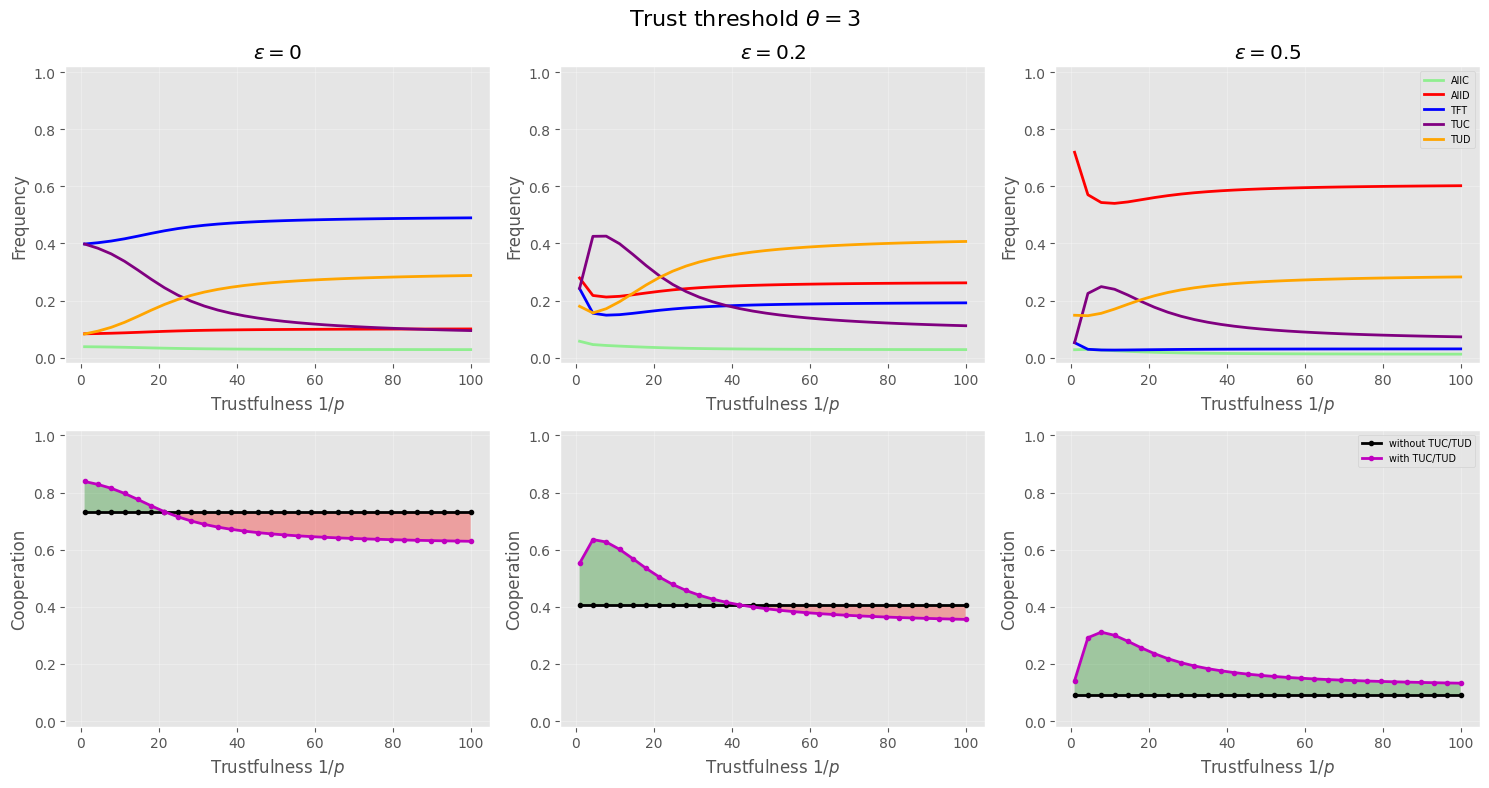

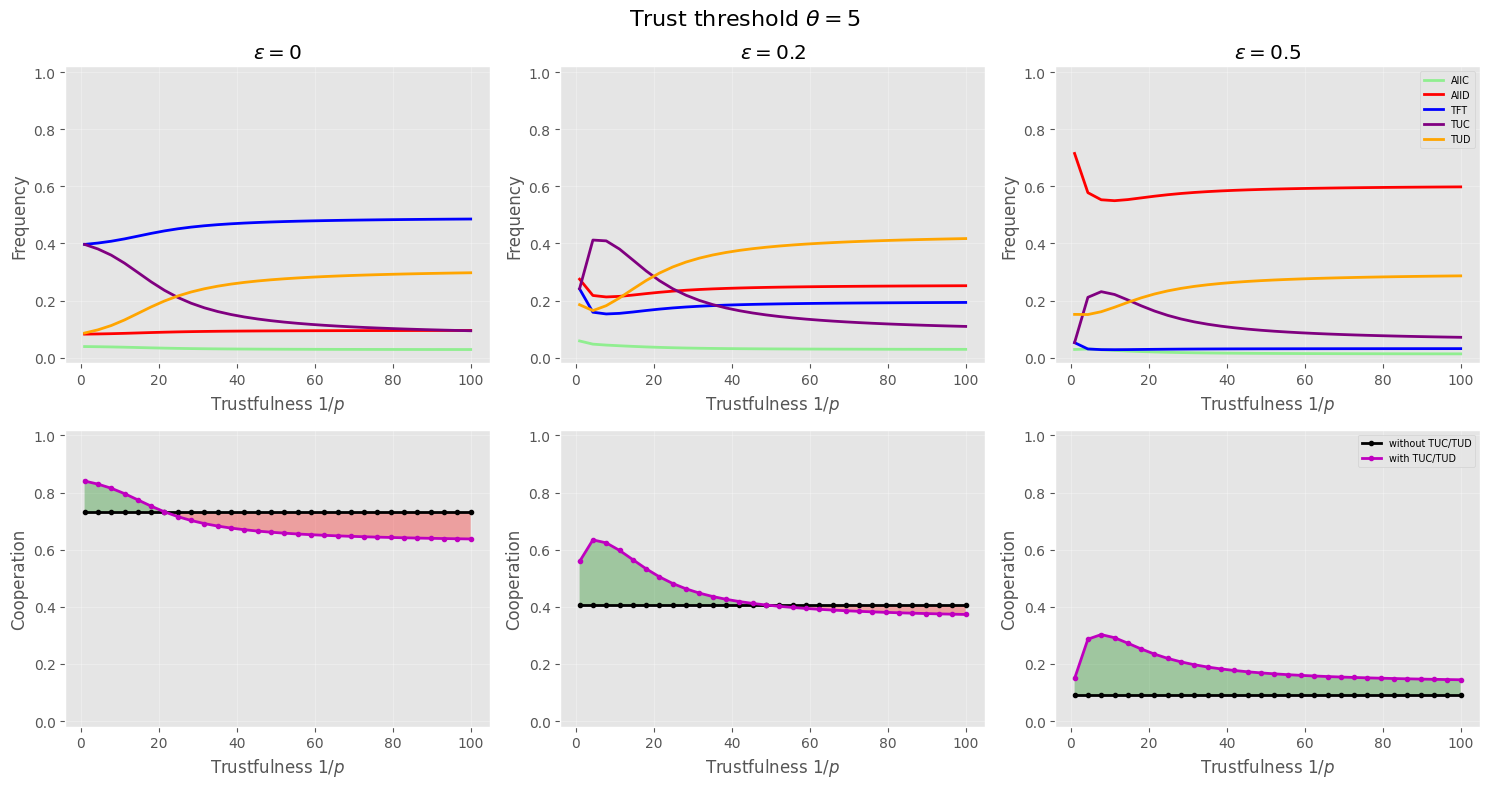

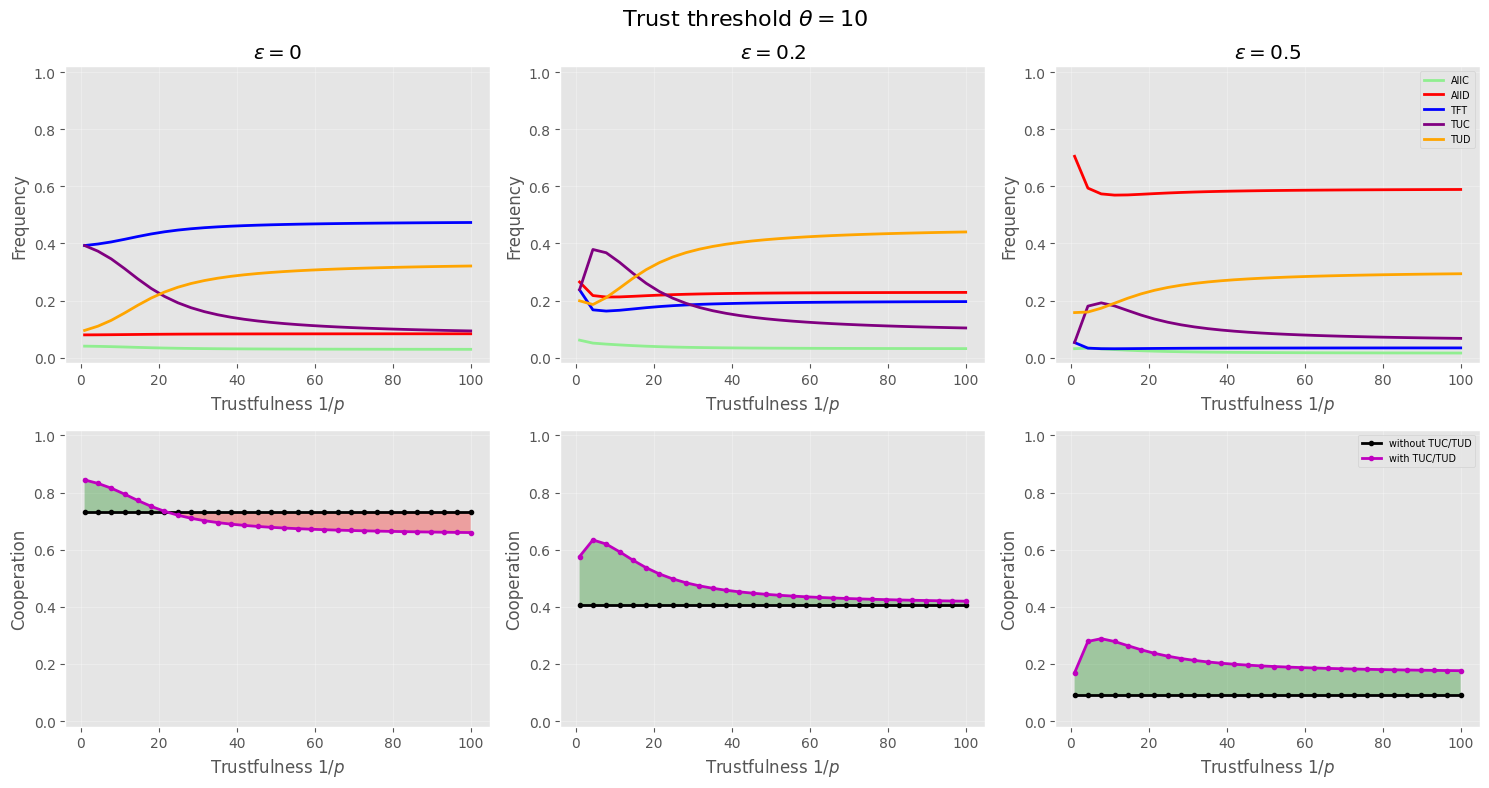

In [234]:
def generate_trustfulness_plots():
    inv_p_values = np.linspace(1, 100, 30)
    p_values = 1.0 / inv_p_values

    epsilons = [0, 0.2, 0.5]
    thetas = [THETA, 5, 10]

    strategies = ["AllC", "AllD", "TFT", "TUC", "TUD"]
    colors = ["lightgreen", "red", "blue", "purple", "orange"]

    for theta in thetas:
        fig, axes = plt.subplots(2, 3, figsize=(15, 8))
        fig.suptitle(f"Trust threshold $\\theta = {theta}$", fontsize=16)

        for j, eps in enumerate(epsilons):
            frequencies_strategies = []
            coop_with = []
            coop_without = []

            # Vary trustfulness
            for p in p_values:
                payoff_matrix = initialize_payoff_matrix(
                    R, S, T, P, theta, p, eps, NUM_ROUNDS
                )

                sd = run_simulation(payoff_matrix, BETA, N)
                frequencies_strategies.append(sd)
                coop_with.append(
                    cooperation_frequency(
                        sd,
                        STRATEGIES,
                        theta,
                        NUM_ROUNDS,
                    )
                )

                sd_base = run_simulation_baseline(payoff_matrix, BETA, N)
                coop_without.append(
                    cooperation_frequency(
                        sd_base,
                        without_cooperation_strategies,
                        theta,
                        NUM_ROUNDS,
                    )
                )

            frequencies_strategies = np.array(frequencies_strategies)

            # Plot Strategies (Top row)
            ax_top = axes[0, j]
            for s_idx in range(5):
                ax_top.plot(
                    inv_p_values,
                    frequencies_strategies[:, s_idx],
                    label=strategies[s_idx],
                    color=colors[s_idx],
                    linewidth=2,
                )
            ax_top.set_ylim(-0.02, 1.02)
            ax_top.set_xlabel(r"Trustfulness $1/p$")
            ax_top.set_ylabel("Frequency")
            ax_top.set_title(f"$\epsilon = {eps}$")
            ax_top.grid(True, alpha=0.3)
            if j == 2:
                ax_top.legend(fontsize="x-small")

            # Plot Cooperation (Bottom row)
            ax_bot = axes[1, j]
            ax_bot.plot(
                inv_p_values, coop_without, "k.-", label="without TUC/TUD", linewidth=2
            )
            ax_bot.plot(
                inv_p_values, coop_with, "m.-", label="with TUC/TUD", linewidth=2
            )

            ax_bot.fill_between(
                inv_p_values,
                coop_without,
                coop_with,
                where=(np.array(coop_with) > np.array(coop_without)),
                facecolor="green",
                alpha=0.3,
                interpolate=True,
            )
            ax_bot.fill_between(
                inv_p_values,
                coop_without,
                coop_with,
                where=(np.array(coop_with) <= np.array(coop_without)),
                facecolor="red",
                alpha=0.3,
                interpolate=True,
            )

            ax_bot.set_ylim(-0.02, 1.02)
            ax_bot.set_xlabel(r"Trustfulness $1/p$")
            ax_bot.set_ylabel("Cooperation")
            ax_bot.grid(True, alpha=0.3)
            if j == 2:
                ax_bot.legend(fontsize="x-small")

        plt.tight_layout()
        plt.show()


generate_trustfulness_plots()